# NLP Project Task 1 : Gender prediction
Realised by Choho Yann Eric CHOHO

# 0. Import library

In [1]:
import os
import pandas as pd

# I. Import Data

In [2]:
data = pd.read_csv('../data/transcriptions_with_sex.csv')
data_weight = pd.read_csv('../data/firstname_with_sex.csv', sep = ';')
print(data.shape)
data.head(3)

(241, 4)


,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme


In [3]:
print(data_weight.shape)
data_weight.head(3)
#print('male', data_weight['male'].sum())
#print('femmale', data_weight['female'].sum())
#print(data_weight['male'].sum() > data_weight['female'].sum())

(6946, 3)


,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047


# II. Data preprocessing

## 2.1 Treating the "ambigu" value issue

In [4]:
# data['sex'].unique()  #see unique values of sex
data[data['sex'] == 'ambigu']

# data[data['sex'] == 'ambigu'].to_csv('ambigu.csv', index = False)  #save in csv for manual correction if need 

,subject_line,groundtruth,prediction,sex
17,421b3e1f-ff91-4871-a8de-3af62c58e3bc,surname: Daniel firstname: Claude occupation: ...,nom: Demil prénom: Claude date_naissance: 33 l...,ambigu
59,8339da37-3493-4684-a9fd-090411f33d01,surname: Gorbinet firstname: Jeanne occupation...,nom: Gorbinet prénom: Jeanne date_naissance: 6...,ambigu
94,e1e6fb82-6417-4dcf-8eaa-7d5a5e9f6551,surname: Roumeau firstname: Claude occupation:...,nom: Roumeau prénom: Vaude date_naissance: 180...,ambigu
123,e6927138-689e-4d70-89c2-cf86f7171fd1,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 84 ...,ambigu
124,5b244d56-e1da-4b57-934a-0a1234f34709,surname: Grillé firstname: Emile occupation: i...,nom: d prénom: Emile date_naissance: 2 lieux_n...,ambigu
130,623f7836-8a46-4078-914e-f3cb9bb51c6e,surname: Martin firstname: Marie occupation: i...,nom: Martin prénom: Marie date_naissance: 47 l...,ambigu
196,91b1d765-2195-462d-a85b-72233327ff4d,surname: Pénot firstname: Claude occupation: s...,nom: Pirot prénom: Claude date_naissance: 1303...,ambigu
204,a17f5fb3-c879-4a9a-a063-e3a43f4f4a3c,surname: Coq firstname: Antonie occupation: id...,nom: d prénom: Entonie date_naissance: 16 lieu...,ambigu
230,e925d46e-1ea7-4537-986e-0fe062d64fa2,surname: Clayeux firstname: Claude occupation:...,nom: Clayeux prénom: Claude date_naissance: 13...,ambigu


variable **"sex"** take 3 values in the dataframe 'data' :  'femme', 'homme' and 'ambigu'.

for the last one 'ambigu', we can manually infer the sex of each individual for whom the variable equals "ambigu" but we can imply some human biais and as this dataset will mostly be used for training and testing model, and that the number of case : we can drop thoses 9 lines.

In [5]:
dataset1 = data.drop(data[data['sex'] == 'ambigu'].index)  
print('different value took by the variable sex : ',dataset1.sex.unique())
print('shape', dataset1.shape)


different value took by the variable sex :  ['femme' 'homme']
shape (232, 4)


In [6]:
# if you want to correct the ambiguous values manually, you can do it in the csv file and then load it again (see below)

data_ambigu_corrected = pd.read_csv('../data/ambigu_corrected.csv')
data_ambigu_corrected = pd.concat([dataset1, data_ambigu_corrected], ignore_index = True)
print('shape', data_ambigu_corrected.shape)
data_ambigu_corrected.head(3)

shape (241, 4)


,subject_line,groundtruth,prediction,sex
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme


- prendre notre modèle et ajouter du bruit pour voir si la perf baisse
- phase d'exploration des modèles et bien justifier le choix des modèles, choix d'hyperparams
- Evaluation : bonne perfomance sur ce que l'on a dans le rapport et ce que eux ils testerons

## 2.2. Restructuration of the dataset for having colonne for each variable

In [7]:
import re
# Improved parsing function to handle nested key-value pairs in each entry
def parse_detailed_info(info):
    # Extracting key-value pairs using regex to handle nested structures
    pattern = r'(\w+):\s*([^:]+?(?=\s+\w+:|$))'
    return {match[0]: match[1].strip().strip('"') for match in re.findall(pattern, info)}

# Apply the improved parsing to each row for 'groundtruth' and 'prediction'
structured_data = []
for _, row in dataset1.iterrows():
    groundtruth = parse_detailed_info(row['groundtruth'])
    prediction = parse_detailed_info(row['prediction'])
    structured_row = {
        **{'subject_line': row['subject_line'], 'sex': row['sex']},
        **{f"groundtruth_{k}": v for k, v in groundtruth.items()},
        **{f"prediction_{k}": v for k, v in prediction.items()}
    }
    structured_data.append(structured_row)

# Create the final structured DataFrame
structured_data = pd.DataFrame(structured_data)
index_to_drop = structured_data[structured_data['sex'] == 'ambigu'].index
structured_data = structured_data.drop(index_to_drop)
print(structured_data.shape)
structured_data.head(3)



(232, 21)


,subject_line,sex,groundtruth_surname,groundtruth_firstname,groundtruth_occupation,groundtruth_link,groundtruth_age,prediction_nom,prediction_prénom,prediction_date_naissance,...,prediction_employeur,groundtruth_employer,prediction_relation,groundtruth_birth_date,groundtruth_lob,prediction_profession,prediction_état_civil,groundtruth_civil_status,prediction_éducation,groundtruth_observation
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,femme,Chardon,Marie,idem,fille,30,Chardon,Marie,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,homme,Lhopital,Louis-Jean,sp,chef,67,Lhopital,Louis Jean,67,...,ahef,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,femme,Papin,Marie,idem,idem,15,Pyrin,Marie,55,...,NaN,idem,d,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# structured_data.columns
# structured_data.isna().sum()
# structured_data['prediction_relation'].unique()

In [9]:
# creer la base groundtruth avec que les colonnes qui commence par groundtruth et de même pour prediction
groundtruth = structured_data.filter(regex='groundtruth')
prediction = structured_data.filter(regex='prediction')
groundtruth.head(5)

y = structured_data['sex'].copy()

## 2.3. Create new variable using different strategy like word termination 

In [10]:
structured_data.columns

Index(['subject_line', 'sex', 'groundtruth_surname', 'groundtruth_firstname',
       'groundtruth_occupation', 'groundtruth_link', 'groundtruth_age',
       'prediction_nom', 'prediction_prénom', 'prediction_date_naissance',
       'prediction_lieux_naissance', 'prediction_employeur',
       'groundtruth_employer', 'prediction_relation', 'groundtruth_birth_date',
       'groundtruth_lob', 'prediction_profession', 'prediction_état_civil',
       'groundtruth_civil_status', 'prediction_éducation',
       'groundtruth_observation'],
      dtype='object')

### 2.3.1 Creation de variable basée sur la terminaison du mot

In [11]:
import pandas as pd

# Assuming structured_data is your DataFrame and prediction_relation is a column in it.

# Create a binary variable for professions ending in "ière" or "ier"
prediction['profession_ier'] = prediction['prediction_profession'].str.contains('ier', na=False).astype(int)
prediction['profession_ière'] = prediction['prediction_profession'].str.contains('ière', na=False).astype(int)

# Create a binary variable for entries containing "femme" or "fille"
prediction['contains_female_terms'] = prediction['prediction_relation'].str.contains('femme|fille', na=False).astype(int)

# Create a binary variable for entries containing "homme" or "fils"
prediction['contains_male_terms'] = prediction['prediction_relation'].str.contains('homme|fils', na=False).astype(int)

# Display the head of the DataFrame to verify the new columns
prediction[['profession_ier','profession_ière', 'contains_female_terms', 'contains_male_terms']].head()

C:\Users\choho\AppData\Local\Temp\ipykernel_29132\3023559200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['profession_ier'] = prediction['prediction_profession'].str.contains('ier', na=False).astype(int)
C:\Users\choho\AppData\Local\Temp\ipykernel_29132\3023559200.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['profession_ière'] = prediction['prediction_profession'].str.contains('ière', na=False).astype(int)
C:\Users\choho\AppData\Local\Temp\ipykernel_29132\3023559200.py:10

,profession_ier,profession_ière,contains_female_terms,contains_male_terms
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [12]:
import pandas as pd

# Assuming structured_data is your DataFrame and prediction_relation is a column in it.

# Create a binary variable for professions ending in "ière" or "ier"
groundtruth['profession_ier'] = groundtruth['groundtruth_occupation'].str.contains('ier', na=False).astype(int)
groundtruth['profession_ière'] = groundtruth['groundtruth_occupation'].str.contains('ière', na=False).astype(int)

# Create a binary variable for entries containing "femme" or "fille"
groundtruth['contains_female_terms'] = groundtruth['groundtruth_link'].str.contains('femme|fille', na=False).astype(int)

# Create a binary variable for entries containing "homme" or "fils"
groundtruth['contains_male_terms'] = groundtruth['groundtruth_link'].str.contains('homme|fils', na=False).astype(int)

# Display the head of the DataFrame to verify the new columns
groundtruth[['profession_ier','profession_ière', 'contains_female_terms', 'contains_male_terms']].head()

terminaison_variable = ['profession_ier','profession_ière', 'contains_female_terms', 'contains_male_terms']

C:\Users\choho\AppData\Local\Temp\ipykernel_29132\4147775227.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groundtruth['profession_ier'] = groundtruth['groundtruth_occupation'].str.contains('ier', na=False).astype(int)
C:\Users\choho\AppData\Local\Temp\ipykernel_29132\4147775227.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groundtruth['profession_ière'] = groundtruth['groundtruth_occupation'].str.contains('ière', na=False).astype(int)
C:\Users\choho\AppData\Local\Temp\ipykernel_29132\4147775227

### 2.3.1 Creation de variable basée sur similarité de chaque mot dans la colonne avec le mot homme / femme

In [13]:
# !python -m spacy download fr_core_news_md  #run only once

In [14]:
import spacy

try:
    nlp = spacy.load('fr_core_news_md')
    print("Model loaded successfully!")
except Exception as e:
    print("Model loading failed:", e)


Model loaded successfully!


In [15]:
import spacy
import pandas as pd

# Charger le modèle de langue française
nlp = spacy.load('fr_core_news_md')

# Créer des vecteurs de référence pour les termes "homme" et "femme"
homme = nlp("homme")
femme = nlp("femme")

# Fonction pour calculer la similarité
def calculate_similarity(text, ref_vector):
    # Convertir le texte en un document spacy
    doc = nlp(text)
    # Calculer et retourner la similarité
    return ref_vector.similarity(doc)

def apply_similarity_to_columns(df, columns):
    for column in columns:
        # Create new columns for each reference term similarity
        df[f'{column}_similarity_to_homme'] = df[column].astype(str).apply(lambda x: calculate_similarity(x, homme))
        df[f'{column}_similarity_to_femme'] = df[column].astype(str).apply(lambda x: calculate_similarity(x, femme))

def get_similarity_columns(df, prefix):
    # Compile a regex pattern to match strings that start with the given prefix,
    # followed by any text, and end with 'similarity_to_homme' or 'similarity_to_femme'
    pattern = re.compile(f'{prefix}.*_similarity_to_(homme|femme)$')
    # Filter columns using this pattern
    return [col for col in df.columns if pattern.match(col)]

In [16]:
groundtruth.columns

Index(['groundtruth_surname', 'groundtruth_firstname',
       'groundtruth_occupation', 'groundtruth_link', 'groundtruth_age',
       'groundtruth_employer', 'groundtruth_birth_date', 'groundtruth_lob',
       'groundtruth_civil_status', 'groundtruth_observation', 'profession_ier',
       'profession_ière', 'contains_female_terms', 'contains_male_terms'],
      dtype='object')

In [17]:
# Columns to apply the similarity calculation
columns_to_process_prediction = ['prediction_nom', 'prediction_prénom', 'prediction_date_naissance',
       'prediction_lieux_naissance', 'prediction_employeur',
       'prediction_relation', 'prediction_profession', 'prediction_état_civil',
       'prediction_éducation']
columns_to_process_groundtruth = ['groundtruth_surname', 'groundtruth_firstname',
       'groundtruth_occupation', 'groundtruth_link', 'groundtruth_age',
       'groundtruth_employer', 'groundtruth_birth_date', 'groundtruth_lob',
       'groundtruth_civil_status', 'groundtruth_observation']

# Apply the similarity function to the specified columns
apply_similarity_to_columns(prediction, columns_to_process_prediction)
apply_similarity_to_columns(groundtruth, columns_to_process_groundtruth)

# Print the resulting DataFrame
prediction.head(3)

C:\Users\choho\AppData\Local\Temp\ipykernel_29132\1414482145.py:16: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return ref_vector.similarity(doc)


C:\Users\choho\AppData\Local\Temp\ipykernel_29132\1414482145.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{column}_similarity_to_homme'] = df[column].astype(str).apply(lambda x: calculate_similarity(x, homme))
C:\Users\choho\AppData\Local\Temp\ipykernel_29132\1414482145.py:16: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return ref_vector.similarity(doc)
C:\Users\choho\AppData\Local\Temp\ipykernel_29132\1414482145.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

,prediction_nom,prediction_prénom,prediction_date_naissance,prediction_lieux_naissance,prediction_employeur,prediction_relation,prediction_profession,prediction_état_civil,prediction_éducation,profession_ier,...,prediction_employeur_similarity_to_homme,prediction_employeur_similarity_to_femme,prediction_relation_similarity_to_homme,prediction_relation_similarity_to_femme,prediction_profession_similarity_to_homme,prediction_profession_similarity_to_femme,prediction_état_civil_similarity_to_homme,prediction_état_civil_similarity_to_femme,prediction_éducation_similarity_to_homme,prediction_éducation_similarity_to_femme
0,Chardon,Marie,30,,NaN,NaN,NaN,NaN,NaN,0,...,-0.094674,-0.089534,-0.094674,-0.089534,-0.094674,-0.089534,-0.094674,-0.089534,-0.094674,-0.089534
1,Lhopital,Louis Jean,67,Sn,ahef,NaN,NaN,NaN,NaN,0,...,0.000000,0.000000,-0.094674,-0.089534,-0.094674,-0.089534,-0.094674,-0.089534,-0.094674,-0.089534
2,Pyrin,Marie,55,NaN,NaN,d,NaN,NaN,NaN,0,...,-0.094674,-0.089534,-0.169017,-0.077888,-0.094674,-0.089534,-0.094674,-0.089534,-0.094674,-0.089534


In [18]:
prediction_similarity_columns = get_similarity_columns(prediction, 'prediction')
groundtruth_similarity_columns = get_similarity_columns(groundtruth, 'groundtruth')

## 2.4. Create Train, Test Dataset 

Create in a one go the train and test dataset on a 70-30 basis to compared the performance on the same test dataset for all models used

In [19]:
from sklearn.model_selection import train_test_split

# Assuming 'dataset1' is your DataFrame
# Set up for 'prediction'

X = structured_data
y = structured_data['sex']  # Assuming 'sex' is the target variable for both

# Split the prediction data into training and testing sets
X_train, X_test, y_train, y_tes = train_test_split(X, y, test_size=0.3, random_state=42)

# Retrieve the indices for the prediction data
train_indices = X_train.index.tolist()
test_indices = X_test.index.tolist()

# Output the indices
print("Prediction - Train line indices:", train_indices)
print("Prediction - Test line indices:", test_indices)


# If you need to access the actual rows for the train and test sets based on these indices
# for prediction or groundtruth, you can use:

# train_rows_pred = prediction.loc[train_indices]
# test_rows_pred = prediction.loc[test_indices]

# train_rows_gt = groundtruth.loc[train_indices]
# test_rows_gt = groundtruth.loc[test_indices]


Prediction - Train line indices: [56, 114, 139, 194, 65, 142, 196, 136, 31, 12, 35, 28, 42, 229, 115, 155, 51, 132, 183, 76, 41, 97, 140, 78, 135, 26, 213, 172, 158, 0, 2, 77, 46, 100, 111, 138, 165, 90, 85, 161, 152, 98, 36, 182, 61, 22, 211, 184, 33, 11, 226, 180, 6, 27, 141, 222, 223, 156, 4, 122, 32, 164, 62, 128, 208, 173, 70, 176, 64, 44, 148, 40, 123, 23, 171, 167, 81, 39, 193, 47, 94, 190, 43, 145, 207, 3, 105, 53, 133, 209, 177, 220, 49, 163, 80, 34, 7, 110, 91, 83, 205, 221, 89, 8, 13, 59, 198, 131, 17, 166, 72, 218, 134, 225, 212, 63, 54, 107, 50, 204, 174, 192, 189, 228, 203, 169, 58, 48, 88, 21, 57, 160, 224, 187, 191, 129, 37, 157, 217, 1, 52, 149, 130, 151, 103, 99, 116, 87, 202, 74, 214, 210, 121, 231, 20, 188, 71, 106, 14, 92, 179, 102]
Prediction - Test line indices: [219, 66, 9, 170, 15, 201, 25, 197, 154, 126, 216, 19, 96, 178, 175, 137, 146, 30, 227, 185, 108, 162, 206, 181, 125, 18, 147, 101, 104, 84, 199, 60, 118, 45, 16, 127, 159, 119, 82, 144, 93, 195, 143, 73,

# III. Descriptive statistics

## 3.1 Sex


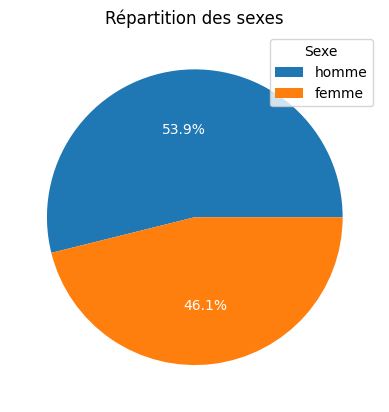

In [20]:
import matplotlib.pyplot as plt

# Compter le nombre d'occurrences de chaque catégorie
counts = dataset1['sex'].value_counts()

# Créer le camembert
# Adjust the autopct parameter to include white color for the text in bold
plt.pie(counts, autopct=lambda p: f'{p:.1f}%', textprops={'color': 'white'})

# Ajouter un titre
plt.title('Répartition des sexes')

# Ajouter une légende
plt.legend(labels=counts.index, title="Sexe")

# Afficher le camembert
plt.show()


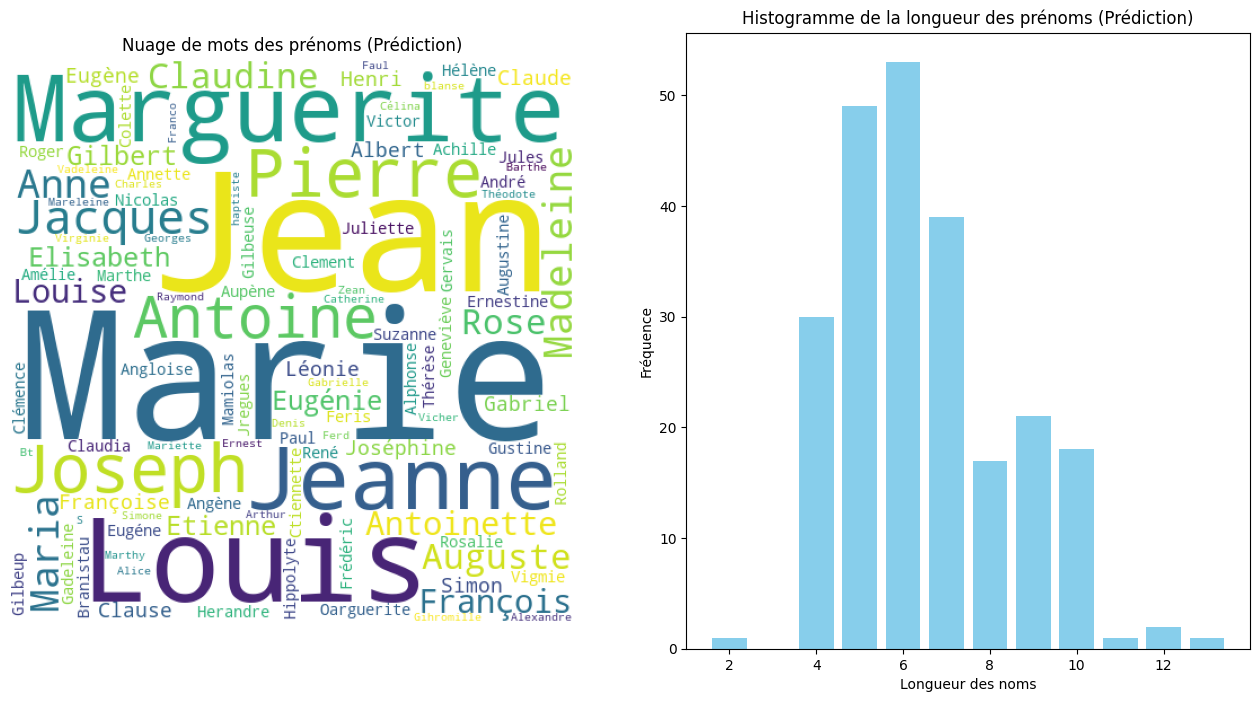

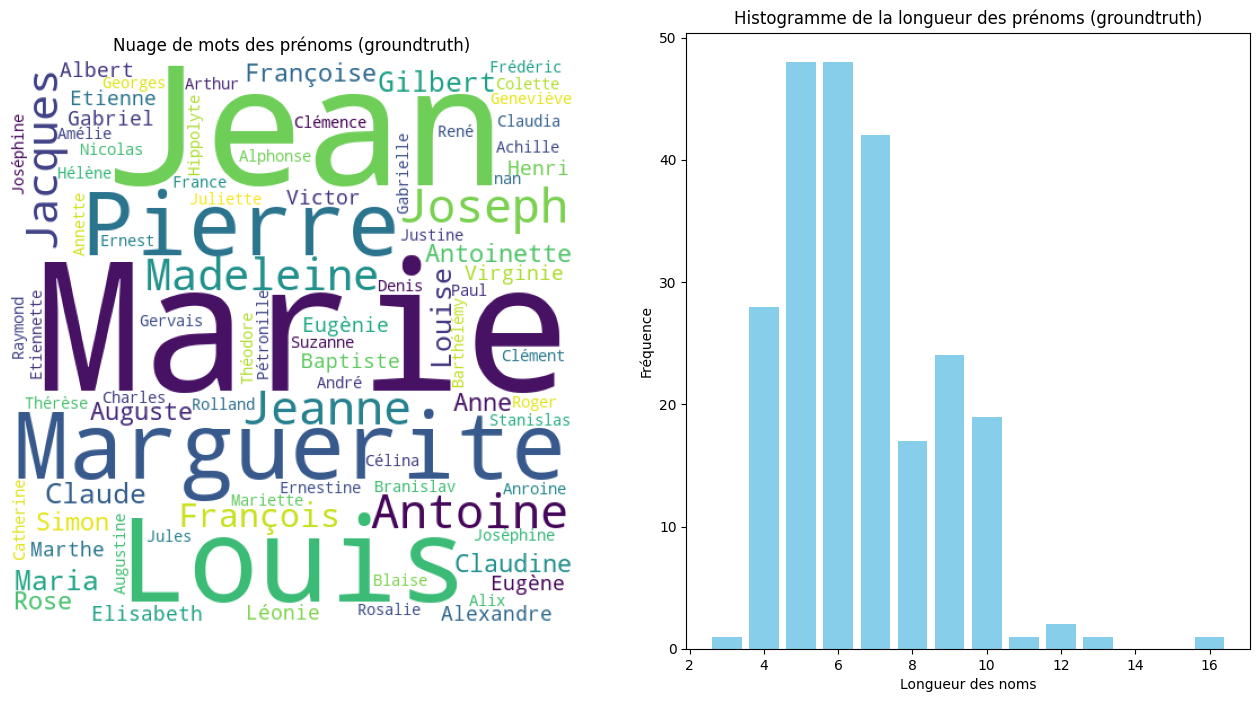

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud

# Prediction
prenoms_prediction = structured_data['prediction_prénom'].tolist()
prenoms_str = " ".join(prenoms_prediction)

# Create a WordCloud for Prediction
wordcloud_prediction = WordCloud(width=500, height=500,
                      background_color='white',
                      stopwords=None,
                      min_font_size=10).generate(prenoms_str)

# Calculate the length of each name and count occurrences for Prediction
prenom_length_pred = pd.Series([len(name) for name in prenoms_prediction])
length_counts_pred = prenom_length_pred.value_counts().sort_index()

# Groundtruth
prenom_groundtruth = structured_data['groundtruth_firstname'].astype(str).tolist()
prenoms_str_2 = " ".join(prenom_groundtruth)

# Create a WordCloud for Groundtruth
wordcloud_groundtruth = WordCloud(width=500, height=500,
                      background_color='white',
                      stopwords=None,
                      min_font_size=10).generate(prenoms_str_2)

# Calculate the length of each name and count occurrences for Groundtruth
prenom_length_gt = pd.Series([len(name) for name in prenom_groundtruth])
length_counts_gt = prenom_length_gt.value_counts().sort_index()

# Create subplots for Prediction
fig_pred, axs_pred = plt.subplots(1, 2, figsize=(16, 8))
axs_pred[0].imshow(wordcloud_prediction)
axs_pred[0].axis("off")
axs_pred[0].set_title('Nuage de mots des prénoms (Prédiction)')

axs_pred[1].bar(length_counts_pred.index, length_counts_pred.values, color='skyblue')
axs_pred[1].set_xlabel('Longueur des noms')
axs_pred[1].set_ylabel('Fréquence')
axs_pred[1].set_title('Histogramme de la longueur des prénoms (Prédiction)')

# Create subplots for Groundtruth
fig_gt, axs_gt = plt.subplots(1, 2, figsize=(16, 8))
axs_gt[0].imshow(wordcloud_groundtruth)
axs_gt[0].axis("off")
axs_gt[0].set_title('Nuage de mots des prénoms (groundtruth)')

axs_gt[1].bar(length_counts_gt.index, length_counts_gt.values, color='skyblue')
axs_gt[1].set_xlabel('Longueur des noms')
axs_gt[1].set_ylabel('Fréquence')
axs_gt[1].set_title('Histogramme de la longueur des prénoms (groundtruth)')

plt.show()


# IV. Modelisation

## 4.1.Dummy classifier

### 4.1.1 Creation of the dummy classifier

faire un dummy classifier à partir que du firsname (prénoms) present dans 

In [22]:
data_weight['predicted_sex'] = data_weight.apply(lambda row: 'homme' if row["male"] > row["female"] else 'femme', axis = 1)
data_weight.head(3)

,firstname,male,female,predicted_sex
0,marie,10145,2390322,femme
1,jean,1869615,6476,homme
2,pierre,1475841,5047,homme


In [23]:
dic = {}

data_weight['predicted_sex'] = data_weight.apply(lambda row: 1 if row["male"] > row["female"] else 0, axis = 1)
list_name = data_weight['firstname'].tolist()
list_pred = data_weight['predicted_sex'].tolist()

for i in range(len(list_name)):
    dic[list_name[i]] = list_pred[i]

# Define a simple mapping from string labels to numeric labels
# Assuming 'femme' is 0 (negative class) and 'homme' is 1 (positive class)
label_mapping = {'femme': 0, 'homme': 1}

def predict_sex(name):
    # mettre en str
    name = str(name)

    # gerer les case
    name = name.lower()
    if name not in dic:
        return 1
    else:
        return dic[name]
    

### 4.1.2 Evaluation : dummy classifier

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Apply the prediction function and calculate metrics
def evaluate_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calculate metrics for training data
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train, zero_division=0)
    recall_train = recall_score(y_train, y_pred_train, zero_division=0)
    f1_train = f1_score(y_train, y_pred_train, zero_division=0)

    # Calculate metrics for testing data
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test, zero_division=0)
    recall_test = recall_score(y_test, y_pred_test, zero_division=0)
    f1_test = f1_score(y_test, y_pred_test, zero_division=0)

    return {
        "Accuracy Train": accuracy_train,
        "Precision Train": precision_train,
        "Recall Train": recall_train,
        "F1-Score Train": f1_train,
        "Accuracy Test": accuracy_test,
        "Precision Test": precision_test,
        "Recall Test": recall_test,
        "F1-Score Test": f1_test
    }

train_rows_pred = prediction.loc[train_indices]['prediction_prénom']
test_rows_pred = prediction.loc[test_indices]['prediction_prénom']

train_rows_gt = groundtruth.loc[train_indices]['groundtruth_firstname']
test_rows_gt = groundtruth.loc[test_indices]['groundtruth_firstname']

y_train = structured_data['sex'].loc[train_indices]
y_test = structured_data['sex'].loc[test_indices]

# Convert y_train and y_test using this mapping
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

print("Accuracy on the whole data set prediction")
y_pred_train = train_rows_pred.apply(predict_sex)
y_pred_test = test_rows_pred.apply (predict_sex)

# Evaluate metrics for prediction
metrics_pred = evaluate_metrics(y_train, y_test, y_pred_train, y_pred_test)


print("Accuracy on the whole data set groundtruth")
y_pred_train = train_rows_gt.apply(predict_sex)
y_pred_test = test_rows_gt.apply (predict_sex)

# Evaluate metrics for groundtruth
metrics_gt = evaluate_metrics(y_train, y_test, y_pred_train, y_pred_test)

# Store metrics in a DataFrame
metrics_df = pd.DataFrame({
    "Metrics Prediction": list(metrics_pred.values()),
    "Metrics Groundtruth": list(metrics_gt.values())
}, index=list(metrics_pred.keys()))

print(metrics_df)
# Create the 'outputs' directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Save the DataFrame to Excel
metrics_df.to_excel('outputs/metrics_df_dummy_classifier.xlsx')

Accuracy on the whole data set prediction
Accuracy on the whole data set groundtruth
                 Metrics Prediction  Metrics Groundtruth
Accuracy Train             0.932099             0.987654
Precision Train            0.911111             0.988235
Recall Train               0.964706             0.988235
F1-Score Train             0.937143             0.988235
Accuracy Test              0.957143             1.000000
Precision Test             0.930233             1.000000
Recall Test                1.000000             1.000000
F1-Score Test              0.963855             1.000000


## 3.2. Optique NLP : 
- Treat data as text 
- Use bag of word / wort to vec
- use a ML model on it


In [25]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Download NLTK resources (if not already installed)
# nltk.download('stopwords')
# nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove specific keywords only
    text = re.sub(r'\b(surname|firstname|nom|prénom|occupation|link|age|date_naissance|lieux_naissance|relation):', '', text)
    
    # Tokenize text and remove punction
    tokens = nltk.word_tokenize(text)
    
    # don't need to remove stopwords and lemmatize because it can have a sens to have patissier different from patissière
    # tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('french') and word.isalpha()]
    tokens = [word for word in tokens ]
    
    return ' '.join(tokens)

# Apply preprocessing to the relevant columns
dataset1['processed_groundtruth'] = dataset1['groundtruth'].apply(preprocess_text)
dataset1['processed_prediction'] = dataset1['prediction'].apply(preprocess_text)


In [26]:
dataset1['processed_groundtruth']

0                            chardon marie idem fille 30
1                         lhopital louis-jean sp chef 67
2               papin marie idem idem employer : idem 15
3      lavocat marie femme birth_date : 1875 lob : rigny
4                                    benne marguerite 78
                             ...                        
236    burlurut pétronille sans profession épouse 61 ans
237                    combey alexandre idem son fils 39
238     collin marguerite idem épouse employer : idem 38
239     dumont etienne fils birth_date : 1900 lob : idem
240    renaut antoinette belle-mère birth_date : 1849...
Name: processed_groundtruth, Length: 232, dtype: object

In [27]:
vectorizer = CountVectorizer()
X_groundtruth = vectorizer.fit_transform(dataset1['processed_groundtruth'])
X_prediction = vectorizer.transform(dataset1['processed_prediction'])


In [28]:
#to run once only
label_mapping = {'femme': 0, 'homme': 1}
dataset1['sex'] = dataset1['sex'].map(label_mapping)
Y = dataset1['sex']  # Target variable

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

X_train = pd.DataFrame.sparse.from_spmatrix(X_groundtruth).iloc[train_indices]
X_test = pd.DataFrame.sparse.from_spmatrix(X_groundtruth).iloc[test_indices]

y_train = Y.iloc[train_indices]
y_test = Y.iloc[test_indices]

# Initialize and train the classifier
#classifier = LogisticRegression(max_iter=1000)
classifier = CatBoostClassifier(n_estimators=1000, verbose=False, random_state=seed)
#classifier = RandomForestClassifier(n_estimators=1000)

classifier.fit(X_train, y_train)

# faire des predictions
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

evaluate_metrics(y_train, y_test, y_pred_train, y_pred_test)


{'Accuracy Train': 0.9753086419753086,
 'Precision Train': 0.9764705882352941,
 'Recall Train': 0.9764705882352941,
 'F1-Score Train': 0.9764705882352941,
 'Accuracy Test': 0.9285714285714286,
 'Precision Test': 0.9487179487179487,
 'Recall Test': 0.925,
 'F1-Score Test': 0.9367088607594937}

# On prediction

In [31]:
import os
import time
import pickle
import math
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

def train_classification_models(X_train, y_train, X_test, y_test, model_names, models, hyperparameters):
    """Function to train classification models optimizing for accuracy, save models, and optimal hyperparameters."""
    print("---------------------------------\nTRAINING IN PROCESS")

    # Training and prediction of models
    for model_name in model_names:
        print('----------------------------------------------------')
        print(f'Training {model_name}')

        start = time.time()

        # Create a pipeline with SimpleImputer and the model
        pipeline = Pipeline([
            ('model', models[model_name])
        ])

        # Adjust hyperparameters for the pipeline
        pipeline_hyperparameters = {'model__' + key: value for key, value in hyperparameters[model_name].items()}

        # Set up GridSearchCV to optimize for accuracy
        search = GridSearchCV(pipeline, pipeline_hyperparameters, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
        search.fit(X_train, y_train)

        best_estimator = search.best_estimator_
        print('Optimal Hyperparameters:', search.best_params_)

        # Prediction and evaluation
        y_pred_train = best_estimator.predict(X_train)
        y_pred_test = best_estimator.predict(X_test)

        # Calculating metrics
        accuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy_test = accuracy_score(y_test, y_pred_test)
        precision_train = precision_score(y_train, y_pred_train, average='macro', zero_division=1)
        recall_train = recall_score(y_train, y_pred_train, average='macro', zero_division=1)
        f1_train = f1_score(y_train, y_pred_train, average='macro', zero_division=1)
        precision_test = precision_score(y_test, y_pred_test, average='macro', zero_division=1)
        recall_test = recall_score(y_test, y_pred_test, average='macro', zero_division=1)
        f1_test = f1_score(y_test, y_pred_test, average='macro', zero_division=1)

        print(f'Train Accuracy: {accuracy_train:.2f}')
        print(f'Test Accuracy: {accuracy_test:.2f}')
        print(f'Train Precision: {precision_train:.2f}')
        print(f'Train Recall: {recall_train:.2f}')
        print(f'Train F1 Score: {f1_train:.2f}')
        print(f'Test Precision: {precision_test:.2f}')
        print(f'Test Recall: {recall_test:.2f}')
        print(f'Test F1 Score: {f1_test:.2f}')

        end = time.time()
        print(f'Execution time: {math.ceil((end - start) / 60)} min')
        print('----------------------------------------------------\n')

        # Save models and hyperparameters
        counter = 0
        while True:
            model_filename = f'results/model_{model_name}_{counter}.pkl'
            params_filename = f'results/hyperparameters_{model_name}_{counter}.txt'
            if not os.path.exists(model_filename) and not os.path.exists(params_filename):
                with open(model_filename, 'wb') as file:
                    pickle.dump(best_estimator, file)
                with open(params_filename, 'w') as file:
                    file.write('Optimal Hyperparameters for ' + model_name + ':\n')
                    file.write(str(search.best_params_))
                break
            counter += 1

    print('Model training completed and saved.')

# Assuming X_train, y_train, X_test, y_test are defined along with model_names, models, and hyperparameters


In [32]:
import numpy as np
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

seed = 42
np.random.seed(seed)

# Models used
models = {
    'CatBoost': CatBoostClassifier(verbose=False, random_state=seed),
    'RandomForest': RandomForestClassifier(verbose=False, random_state=seed),
    'LogisticRegression': LogisticRegression(max_iter=1000),

}

# Hyperparameter grids
hyperparameters = {
    'CatBoost': {
        'n_estimators': [1000, 1500, 2000],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [3, 6, 9]
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
          'LogisticRegression': {
        'C': np.logspace(-4, 4, 10),  # Expanding to a wider range of C
        'solver': ['liblinear', 'lbfgs']  # Including different solvers
    }
    }
    

In [33]:

# Model names
#model_names = ['LogisticRegression', 'CatBoost', 'RandomForest']
model_names = ['LogisticRegression']

# Replace 'train_prediction_models' with your classification training function
train_classification_models(X_train, y_train, X_test, y_test, model_names, models, hyperparameters)


---------------------------------
TRAINING IN PROCESS
----------------------------------------------------
Training LogisticRegression
Optimal Hyperparameters: {'model__C': 2.782559402207126, 'model__solver': 'liblinear'}
Train Accuracy: 0.99
Test Accuracy: 0.89
Train Precision: 0.99
Train Recall: 0.99
Train F1 Score: 0.99
Test Precision: 0.88
Test Recall: 0.89
Test F1 Score: 0.88
Execution time: 1 min
----------------------------------------------------

Model training completed and saved.


## 4.3. Optique ML directe

### First good model

In [29]:
# faire un train test split
from sklearn.model_selection import train_test_split
# import randomforest 
from sklearn.ensemble import RandomForestClassifier
print("on groundtruth")

# faire un one hot encoding pour les colones de groundtruth avec plusieurs valeurs
X = pd.get_dummies(prediction, drop_first=False)


X_train = X.iloc[train_indices]
X_test = X.iloc[test_indices]
#y_train
#y_test = train_test_split(X , y, test_size=0.2, random_state=42)

# creer un modele de regression logistique
from sklearn.linear_model import LogisticRegression

#model = LogisticRegression(max_iter=1000)
#model = CatBoostClassifier(n_estimators=1000, verbose=False, random_state=seed)
model = RandomForestClassifier(n_estimators=1000)

# entrainer le modele
model.fit(X_train, y_train)

# faire des predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# evaluer le modele
evaluate_metrics(y_train, y_test, y_pred_train, y_pred_test)

on groundtruth


{'Accuracy Train': 1.0,
 'Precision Train': 1.0,
 'Recall Train': 1.0,
 'F1-Score Train': 1.0,
 'Accuracy Test': 0.8857142857142857,
 'Precision Test': 0.8636363636363636,
 'Recall Test': 0.95,
 'F1-Score Test': 0.9047619047619048}

# III. Analysis with Prompt engeneering

# Prompt Definition

In [73]:
import os

os.environ['HUGGINGFACEHUB_API_TOKEN'] = 'XXXXX' # token Hugging face to replace XXXXX 

# don't forget to go to the huggingface website and create an account and get your api token
# then on https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1 agree to the terms before using the model

Modèle Avec Contexte Historique pour un Prénom

In [67]:
prompt_avec_contexte_historique = """[INST]
Vous disposez de données historiques de la période 1836 à 1936 en France pour aider à déterminer le genre probable associé à un prénom.

Voici le prénom que vous devez analyser (entre le token spécial [N] et [/N]):
[N]
{first_name}
[/N]

En vous basant sur les contextes historiques et l'usage courant de la période fournie, quel est le genre le plus probable pour ce prénom ?
Voici vos options (entre le token spécial [G] et [/G]) :

Vous êtes tenu de donner une réponse même si vous ne disposez pas des informations nécessaires.

[G]
Genres possibles :
- Masculin
- Féminin
[/G]

Veuillez fournir votre réponse ci-dessous (entre le token spécial [ANSW] et [/ANSW]) :
Réponse : [/INST]"""


Modèle Avec Contexte Historique et Informations Personnelles

In [68]:
prompt_avec_contexte_historique_et_infos_personnelles = """[INST]
Vous êtes chargé d'analyser le contexte historique et les données démographiques pour évaluer le genre probable d'un individu en fonction de plusieurs attributs personnels. Utilisez uniquement les informations fournies dans les tokens désignés.

Voici les détails personnels que vous devez considérer :
- Date de naissance : [DOB]{date_naissance}[/DOB]
- Lieu de naissance : [POB]{lieux_naissance}[/POB]
- Employeur : [EMP]{employeur}[/EMP]
- Relation avec le chef de ménage : [REL]{relation_au_chef_de_menage}[/REL]
- Profession : [PROF]{profession}[/PROF]
- Statut marital : [MAR]{état_civil}[/MAR]
- Éducation : [EDU]{éducation}[/EDU]

En vous basant sur les informations fournies et les données historiques de 1836 à 1936 en France, décidez du genre le plus probable de l'individu. Voici vos options (entre le token spécial [G] et [/G]) :
[G]
Genres possibles :
- Masculin
- Féminin
[/G]

Veuillez fournir votre réponse ci-dessous (entre le token spécial [ANSW] et [/ANSW]) :
Réponse : [/INST]"""


Modèle Sans Contexte Temporel ou Informations Personnelles


In [69]:
prompt_sans_contexte_temporel_sans_infos_personnelles = """[INST]
Déterminez le genre probable associé à un prénom.

Voici le prénom que vous devez analyser (entre le token spécial [N] et [/N]) :
[N]
{first_name}
[/N]

Quel est le genre le plus probable pour ce prénom ? Voici vos options (entre le token spécial [G] et [/G]) :

[G]
Genres possibles :
- Masculin
- Féminin

[/G]

Veuillez fournir votre réponse ci-dessous (entre le token spécial [ANSW] et [/ANSW]) :
Réponse : [/INST]"""


Modèle Sans Contexte Temporel Avec Informations Personnelles


In [76]:
prompt_sans_contexte_temporel_avec_infos_personnelles = """[INST]
Vous êtes chargé d'analyser le contexte historique et les données démographiques pour évaluer le genre probable d'un individu en fonction de plusieurs attributs personnels. Utilisez uniquement les informations fournies dans les tokens désignés.

Voici les détails personnels que vous devez considérer :
- Date de naissance : [DOB]{date_naissance}[/DOB]
- Lieu de naissance : [POB]{lieux_naissance}[/POB]
- Employeur : [EMP]{employeur}[/EMP]
- Relation avec le chef de ménage : [REL]{relation_au_chef_de_menage}[/REL]
- Profession : [PROF]{profession}[/PROF]
- Statut marital : [MAR]{état_civil}[/MAR]
- Éducation : [EDU]{éducation}[/EDU]

En vous basant sur les informations fournies et sur les données historiques de 1836 à 1936 en France, décidez du genre le plus probable de l'individu. Voici vos options (entre le token spécial [G] et [/G]) :
[G]
Genres possibles :
- Masculin
- Féminin
[/G]

Vous êtes tenu de fournir une réponse même si les informations semblent insuffisantes.

Veuillez fournir votre réponse ci-dessous (entre le token spécial [ANSW] et [/ANSW]) :
Réponse : [/INST]
"""


In [75]:
from langchain import LLMChain, HuggingFaceHub, PromptTemplate

# Create a PromptTemplate object
gender_prompt = PromptTemplate(template=prompt_sans_contexte_temporel_sans_infos_personnelles, input_variables=["first_name"])

# Setup the model repository
model_repo = "mistralai/Mixtral-8x7B-Instruct-v0.1"


# Initialize LLMChain with the gender prompt template
llm_gender = LLMChain(prompt=gender_prompt, 
                      llm=HuggingFaceHub(repo_id=model_repo,
                                         model_kwargs={"max_new_tokens":200, "temperature":0.00001}))


In [77]:
# Example function to extract only the answer
def get_only_answer(text):
    id = text.find("[/INST]")
    return text[id+9:].strip()  # Adjust index to skip past "[/INST]"

# Function to get only the output, looking for "Male" or "Female"
def get_only_output(text):
    text_lower = text.lower()

    id_male = text_lower.find("male")
    id_female = text_lower.find("female")

    if id_female != -1:
        return "F"
    if id_male != -1:
        return "M"

# one row prediction


In [78]:
# Simulate a model invocation
# Prepare your input for the model as a list of dictionaries
first_name = "yann"
date_naissance = "01/01/1990"
education = "bac+5"
lieux_naissance = "paris"
employeur = "google"
profession = "data scientist"
relation_au_chef_de_menage = "fils"
état_civil = "célibataire"

# Generate response using the model
response_text = llm_gender.invoke({"first_name" : first_name,
                                   "date_naissance" : date_naissance,
                                   "education": education,
                                    "lieux_naissance": lieux_naissance,
                                    "employeur": employeur,
                                    "profession": profession,
                                    "relation_au_chef_de_menage": relation_au_chef_de_menage,
                                    "état_civil": état_civil
                                    })["text"]
# Print the processed output
print(get_only_output(get_only_answer(response_text)))


None


In [81]:
print(response_text)

[INST]
Déterminez le genre probable associé à un prénom.

Voici le prénom que vous devez analyser (entre le token spécial [N] et [/N]) :
[N]
yann
[/N]

Quel est le genre le plus probable pour ce prénom ? Voici vos options (entre le token spécial [G] et [/G]) :

[G]
Genres possibles :
- Masculin
- Féminin

[/G]

Veuillez fournir votre réponse ci-dessous (entre le token spécial [ANSW] et [/ANSW]) :
Réponse : [/INST] [ANSW]
Masculin
[/ANSW]
Explication :
Le prénom "Yann" est principalement utilisé pour les hommes dans les cultures francophones, anglophones et germanophones, entre autres. C'est la forme bretonne du nom Jean et il est considéré comme un prénom masculin dans la plupart des contextes culturels. Cependant, il est important de noter que les


# Multiple rows prediction

In [81]:
prediction.columns

Index(['prediction_nom', 'prediction_prénom', 'prediction_date_naissance',
       'prediction_lieux_naissance', 'prediction_employeur',
       'prediction_relation', 'prediction_profession', 'prediction_état_civil',
       'prediction_éducation', 'profession_ier', 'profession_ière',
       'contains_female_terms', 'contains_male_terms',
       'prediction_nom_similarity_to_homme',
       'prediction_nom_similarity_to_femme',
       'prediction_prénom_similarity_to_homme',
       'prediction_prénom_similarity_to_femme',
       'prediction_date_naissance_similarity_to_homme',
       'prediction_date_naissance_similarity_to_femme',
       'prediction_lieux_naissance_similarity_to_homme',
       'prediction_lieux_naissance_similarity_to_femme',
       'prediction_employeur_similarity_to_homme',
       'prediction_employeur_similarity_to_femme',
       'prediction_relation_similarity_to_homme',
       'prediction_relation_similarity_to_femme',
       'prediction_profession_similarity_to_hom

In [ ]:

outputs = []
lines_to_test = prediction.shape[0]
for i in range(prediction.shape[0]):    
    full_answer = llm_gender.run({
        "first_name": prediction.iloc[i]["prediction_prénom"],
        "date_naissance": prediction.iloc[i]["prediction_date_naissance"],
        "education": prediction.iloc[i]["prediction_éducation"],
        "lieux_naissance": prediction.iloc[i]["prediction_lieux_naissance"],
        "employeur": prediction.iloc[i]["prediction_employeur"],
        "profession": prediction.iloc[i]["prediction_profession"],
        "relation_au_chef_de_menage": prediction.iloc[i]["prediction_relation"],
        "état_civil": prediction.iloc[i]["prediction_état_civil"]
    })
    outputs.append(full_answer)
    print(f"Progress: {i+1}/{lines_to_test}")
    outputs_df = pd.DataFrame(outputs)
    outputs_df.to_csv(f'outputs/outputs_{i}.csv', index=False)
   

In [ ]:
starting_index = 71
outputs = []
lines_to_test = prediction.shape[0]
for i in range(starting_index, prediction.shape[0]):
    full_answer = llm_gender.run({
        "first_name": prediction.iloc[i]["prediction_prénom"],
        "date_naissance": prediction.iloc[i]["prediction_date_naissance"],
        "education": prediction.iloc[i]["prediction_éducation"],
        "lieux_naissance": prediction.iloc[i]["prediction_lieux_naissance"],
        "employeur": prediction.iloc[i]["prediction_employeur"],
        "profession": prediction.iloc[i]["prediction_profession"],
        "relation_au_chef_de_menage": prediction.iloc[i]["prediction_relation"],
        "état_civil": prediction.iloc[i]["prediction_état_civil"]
    })
    outputs.append(full_answer)
    print(f"Progress: {i+1}/{lines_to_test}")
    outputs_df = pd.DataFrame(outputs)
    outputs_df.to_csv(f'outputs/outputs_{i}.csv', index=False)
   

In [109]:
#outputs2 = [get_only_answer(output) for output in outputs if output is not None]
outputs2 = [get_only_output(output) for output in outputs if output is not None]


from sklearn.metrics import accuracy_score

# Clean the data by removing entries where outputs are None
valid_indices = [i for i, output in enumerate(outputs2) if output is not None]
cleaned_outputs = [outputs2[i] for i in valid_indices]
cleaned_data = structured_data.loc[valid_indices]

# Map 'homme'/'femme' to 'M'/'F' for the actual labels
actual_labels = cleaned_data['sex'].apply(lambda x: "M" if x == 'homme' else "F")

# Calculate the accuracy score
accuracy = accuracy_score(actual_labels, cleaned_outputs)
print("Accuracy of the model:", accuracy)


['F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'M',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'F',
 'F',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'M',
 'M',
 'M',
 'F',
 'M',
 'M',
 'F',
 'M',
 'M',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 'M',
 'F',
 'M',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 None,
 'M',
 'F',
 'M',
 'M',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'F',
 'F',
 None,
 'M',
 'M',
 'M',
 'F',
 'F',
 'M',
 'F',
 'M',
 'M',
 'M',
 'F',
 None,
 'M',
 'M',
 'F',
 'M',
 'F',
 'M',
 'M',
 'M',
 'F',
 None,
 'M',
 'F',
 'M',
 'F',
 'F',
 'M',
 'M',
 'M',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'M',
 'F',
 None,
 'F',
 'F',
 'M',
 'M',
 'M',
 'M',
 'M',
 'M',
 'F',
 'M',
 'F',
 'M',
 'F',
 'F',
 'M',
 'F',
 'F',
 'M',
 'M',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'F',
 'F',
 'F',
 'F',
 'M',
 'M',
 'F',
 'M',
 'M',
 'F',
 'M',
 None,
 'M',
 'M',
 'F',
 'F',
 'M',
 'F'

In [112]:
outputs2
#SAVE OUTPUTS
outputs2 = pd.DataFrame(outputs2)
outputs2.to_csv('outputs2.csv', index=False)

# III. Caracter level analysis 

## 1.1 Necessary libraries

In [36]:
import pandas as pd                       
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow import keras
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, GRU, SimpleRNN, LSTM, Bidirectional, Activation, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

## 1.2 Download the dataset

In [39]:
"""
import requests
url = "https://www.insee.fr/fr/statistiques/fichier/7633685/nat2022_csv.zip"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)
"""

data_insee = pd.read_csv('../data/nat2022_csv.zip', sep=';', encoding = 'utf-8', compression='zip') 
#supression du mot "_PRENOMS_RARES" mis surement pour question d'anonymisation
data_insee.drop(data_insee[data_insee['preusuel'] == '_PRENOMS_RARES'].index, inplace = True)

data_weight['predicted_sex'] = data_weight.apply(lambda row: 'homme' if row["male"] > row["female"] else 'femme', axis = 1)
data_weight.head(3)

# faire une analysis at characters levels of firsname
characteres_data = data_weight['firstname'].apply(lambda x: len(x))

#Modalité : 1 pour masculin, 2 pour féminin

data_insee.head()

,sexe,preusuel,annais,nombre
123,1,A,1980,3
124,1,A,1998,3
125,1,A,XXXX,21
126,1,AADAM,2009,4
127,1,AADAM,2014,3


In [ ]:
#data_insee['annais'].unique()
#data_insee["longueur_nom"] = data_insee['preusuel'].apply(lambda x: len(x))
#data[data_insee['longueur_nom'] == 1]


In [46]:
# Convert 'annais' to numeric, setting errors='coerce' to turn non-convertible values to NaN
data_insee['annais'] = pd.to_numeric(data_insee['annais'], errors='coerce')

# Filter rows where 'annais' is between 1900 and 1936
data_insee_1900_1936 = data_insee[(data_insee['annais'] >= 1900) & (data_insee['annais'] <= 2000)]

print(data_insee_1900_1936)


        sexe preusuel  annais  nombre
123        1        A  1980.0       3
124        1        A  1998.0       3
135        1    AADEL  1976.0       5
136        1    AADEL  1978.0       3
137        1    AADEL  1980.0       3
...      ...      ...     ...     ...
702892     2  ZULMIRA  1971.0       4
702893     2  ZULMIRA  1973.0       4
702894     2  ZULMIRA  1974.0       3
702895     2  ZULMIRA  1975.0       3
702988     2    ZYNEB  1999.0       3

[379868 rows x 4 columns]


# manage the accent

In [50]:
data_insee.iloc[430421].apply(lambda x: str(x).lower())

sexe             2
preusuel       éve
annais      2014.0
nombre           6
Name: 430667, dtype: object

In [56]:
def normalize_name(name):
    replacements = {
        'á': 'A', 'à': 'A', 'â': 'A', 'ä': 'A', 'ã': 'A', 'å': 'A', 'Á': 'A', 'À': 'A', 'Â': 'A', 'Ä': 'A', 'Ã': 'A', 'Å': 'A',
        'é': 'E', 'è': 'E', 'ê': 'E', 'ë': 'E', 'É': 'E', 'È': 'E', 'Ê': 'E', 'Ë': 'E',
        'í': 'I', 'ì': 'I', 'î': 'I', 'ï': 'I', 'Í': 'I', 'Ì': 'I', 'Î': 'I', 'Ï': 'I',
        'ó': 'O', 'ò': 'O', 'ô': 'O', 'ö': 'O', 'õ': 'O', 'ø': 'O', 'Ó': 'O', 'Ò': 'O', 'Ô': 'O', 'Ö': 'O', 'Õ': 'O', 'Ø': 'O',
        'ú': 'U', 'ù': 'U', 'û': 'U', 'ü': 'U', 'Ú': 'U', 'Ù': 'U', 'Û': 'U', 'Ü': 'U',
        'ç': 'C', 'ñ': 'N', 'Ç': 'C', 'Ñ': 'N'
    }
    for accented_char, unaccented_char in replacements.items():
        name = name.replace(accented_char, unaccented_char)
    return name.upper()


# regroup

In [58]:
data_insee['preusuel'] = data_insee['preusuel'].astype(str).apply(normalize_name)


result = data_insee.groupby(['preusuel', 'sexe'])['nombre'].sum().unstack(fill_value=0)

# Reset index pour transformer les index en colonne 'preusuel'
result.reset_index(inplace=True)

# Renommer les colonnes si nécessaire
result.columns = ['firstname', 'male', 'female']

# Remplir les NaN par 0 si jamais il y en a après unstack
result.fillna(0, inplace=True)

# Convertir en entier si les nombres ne sont pas déjà en entier
result['male'] = result['male'].astype(int)
result['female'] = result['female'].astype(int)

# Sauvegarder en CSV
result.to_csv('../data/prenom_frequence_sexe.csv', sep=';', index=False)

# Affichage du résultat final pour vérification
result

result['sex'] = result.apply(lambda row: 'homme' if row["male"] > row["female"] else 'femme', axis = 1)

result

,firstname,male,female,sex
0,A,27,0,homme
1,AADAM,36,0,homme
2,AADEL,57,0,homme
3,AADHIRA,0,30,femme
4,AADIL,191,0,homme
...,...,...,...,...
33589,ZYGMUNT,328,0,homme
33590,ZYHAD,20,0,homme
33591,ZYNA,0,77,femme
33592,ZYNEB,0,129,femme


### 1.2.1 Preparing the data 

In [118]:
#y = data_weight['predicted_sex']
#y = y.astype("category").cat.codes.values    # y labels into numbers 0 is F and 1 is M
#names = data_weight['firstname'].apply(lambda x: x.lower())             # input names

y = result['sex']
y = y.astype("category").cat.codes.values    #0 is F and 1 is M
names = result['firstname'].apply(lambda x: str(x).upper)             # input names

In [119]:
print("M : " + str(sum(y==1)))
print("F : " + str(sum(y==0)))
print(len(y))

M : 15764
F : 17830
33594


## 1.3 Encoding Words

Neural networks can only learn to find patterns in numerical data, so it is necessary to convert our data into numeric values with word encoding or tokenization. 

In [122]:
names

0        <built-in method upper of str object at 0x0000...
1        <built-in method upper of str object at 0x0000...
2        <built-in method upper of str object at 0x0000...
3        <built-in method upper of str object at 0x0000...
4        <built-in method upper of str object at 0x0000...
                               ...                        
33589    <built-in method upper of str object at 0x0000...
33590    <built-in method upper of str object at 0x0000...
33591    <built-in method upper of str object at 0x0000...
33592    <built-in method upper of str object at 0x0000...
33593    <built-in method upper of str object at 0x0000...
Name: firstname, Length: 33594, dtype: object

In [120]:
#word encoding
maxlen = 20                                               # max lenght of a name
'''Define a vocabulary which corresponds to all the unique letters encountered'''
vocab = set(' '.join([str(i) for i in names]))            # creating a vocab
vocab.add('END')
len_vocab = len(vocab)
''' The dictionary maps each letter of vocabulary to a number '''
char_index = dict((c, i) for i, c in enumerate(vocab))    # creating a dictionary

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

In [75]:
x = prepare_encod_names(names.values)   # Now the names are encod as a vector of numbers 

In [76]:
np.shape(x)

(33594, 20, 32)

## 1.4 Split the data into test and train

In [77]:
# train, val, test set will be 60%, 20%, 20% of the dataset respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=40)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

In [79]:
x_train.shape

(21500, 20, 32)

In [78]:
y_train.shape

(21500,)

In [70]:
# Metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [71]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_f1_score', mode="max", patience=5)]

In [72]:
# Results
def results(scores):
    print("Accuracy: %.2f%%" % (scores[1]*100))
    print("F1 score: %.2f%%" % (scores[2]*100)) 

## 1.5 Building the CNN Model

In [80]:
"""
checkpoint_filepath = './models/cnn_softmax'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='f1_score',
    mode='max',
    save_best_only=True)
"""
CNNmodel = keras.Sequential()
CNNmodel.add(Conv1D(256, 3, activation='relu', kernel_initializer='he_uniform', input_shape=(maxlen, 32)))
CNNmodel.add(Conv1D(256, 3, activation='relu'))
CNNmodel.add(Flatten())
CNNmodel.add(Dropout(0.2))
CNNmodel.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNNmodel.add(Dropout(0.2))
CNNmodel.add(Dense(1, activation='sigmoid', kernel_initializer='he_uniform'))

opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

CNNmodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', f1_score])

CNNhistory = CNNmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
CNNscores = CNNmodel.evaluate(x_test, y_test) 
results(CNNscores)

Epoch 1/100
84/84 [==============================] - 4s 33ms/step - loss: 0.4796 - accuracy: 0.7697 - f1_score: 0.7446 - val_loss: 0.4213 - val_accuracy: 0.8158 - val_f1_score: 0.7916
Epoch 2/100
84/84 [==============================] - 3s 30ms/step - loss: 0.3678 - accuracy: 0.8415 - f1_score: 0.8344 - val_loss: 0.3694 - val_accuracy: 0.8406 - val_f1_score: 0.8435
Epoch 3/100
84/84 [==============================] - 3s 30ms/step - loss: 0.3314 - accuracy: 0.8587 - f1_score: 0.8518 - val_loss: 0.3427 - val_accuracy: 0.8510 - val_f1_score: 0.8481
Epoch 4/100
84/84 [==============================] - 3s 33ms/step - loss: 0.3069 - accuracy: 0.8711 - f1_score: 0.8645 - val_loss: 0.3403 - val_accuracy: 0.8527 - val_f1_score: 0.8524
Epoch 5/100
84/84 [==============================] - 3s 34ms/step - loss: 0.2734 - accuracy: 0.8879 - f1_score: 0.8818 - val_loss: 0.3220 - val_accuracy: 0.8597 - val_f1_score: 0.8554
Epoch 6/100
84/84 [==============================] - 3s 32ms/step - loss: 0.2527

## 1.6 Building the RNN Model

In [88]:
RNNmodel=keras.Sequential()
RNNmodel.add(SimpleRNN(32, input_shape=(x_train.shape[1],x_train.shape[2]), activation='tanh', return_sequences=True))
RNNmodel.add(TimeDistributed(Dense(1))) 
RNNmodel.add(Flatten())
RNNmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
RNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])

RNNhistory=RNNmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
RNNscores = RNNmodel.evaluate(x_test, y_test) 
results(RNNscores)

Epoch 1/100
84/84 [==============================] - 2s 10ms/step - loss: 0.5561 - accuracy: 0.7182 - f1_score: 0.6914 - val_loss: 0.4950 - val_accuracy: 0.7762 - val_f1_score: 0.7849
Epoch 2/100
84/84 [==============================] - 0s 5ms/step - loss: 0.4652 - accuracy: 0.7929 - f1_score: 0.7826 - val_loss: 0.4458 - val_accuracy: 0.8050 - val_f1_score: 0.7945
Epoch 3/100
84/84 [==============================] - 1s 6ms/step - loss: 0.4254 - accuracy: 0.8141 - f1_score: 0.8074 - val_loss: 0.4279 - val_accuracy: 0.8106 - val_f1_score: 0.7947
Epoch 4/100
84/84 [==============================] - 1s 8ms/step - loss: 0.4052 - accuracy: 0.8240 - f1_score: 0.8172 - val_loss: 0.4109 - val_accuracy: 0.8212 - val_f1_score: 0.8206
Epoch 5/100
84/84 [==============================] - 1s 9ms/step - loss: 0.4007 - accuracy: 0.8266 - f1_score: 0.8205 - val_loss: 0.4026 - val_accuracy: 0.8305 - val_f1_score: 0.8211
Epoch 6/100
84/84 [==============================] - 0s 6ms/step - loss: 0.3866 - ac

## 1.7 Building the GRU Model

In [90]:
GRUmodel=keras.Sequential()
GRUmodel.add(GRU(32, input_shape=(x_train.shape[1],x_train.shape[2]),activation='tanh', return_sequences=True))
GRUmodel.add(TimeDistributed(Dense(1))) 
GRUmodel.add(Flatten())
GRUmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
GRUmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])

GRUhistory=GRUmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
GRUscores = GRUmodel.evaluate(x_test, y_test)
results(GRUscores)

Epoch 1/100
84/84 [==============================] - 4s 23ms/step - loss: 0.5960 - accuracy: 0.6660 - f1_score: 0.5742 - val_loss: 0.4496 - val_accuracy: 0.8041 - val_f1_score: 0.7987
Epoch 2/100
84/84 [==============================] - 1s 14ms/step - loss: 0.4221 - accuracy: 0.8159 - f1_score: 0.8094 - val_loss: 0.4168 - val_accuracy: 0.8182 - val_f1_score: 0.8226
Epoch 3/100
84/84 [==============================] - 1s 13ms/step - loss: 0.3862 - accuracy: 0.8293 - f1_score: 0.8244 - val_loss: 0.3886 - val_accuracy: 0.8300 - val_f1_score: 0.8187
Epoch 4/100
84/84 [==============================] - 1s 15ms/step - loss: 0.3673 - accuracy: 0.8393 - f1_score: 0.8324 - val_loss: 0.3744 - val_accuracy: 0.8374 - val_f1_score: 0.8336
Epoch 5/100
84/84 [==============================] - 1s 14ms/step - loss: 0.3504 - accuracy: 0.8468 - f1_score: 0.8397 - val_loss: 0.3622 - val_accuracy: 0.8432 - val_f1_score: 0.8335
Epoch 6/100
84/84 [==============================] - 1s 16ms/step - loss: 0.3276

## 1.8 Building the DNN Model

In [83]:
DNNmodel = keras.Sequential()                                   # Sequential model
n_inputs = 32                                                   # nº of states  
inputs = keras.Input(shape=(maxlen,n_inputs,), name = 'input')      # Define inputs
l1=layers.Dense(64, activation='relu', name = 'hidden_layer_1')(inputs) 
ly2=layers.Dense(128, activation='softplus', name = 'hidden_layer_2')(l1) 
l3=layers.Dropout(0.25)(ly2)
l4=layers.Flatten()(l3)                 
output=[] 
output.append(layers.Dense(1, activation='sigmoid', name = 'output')(l4))                                    
DNNmodel = keras.Model(inputs=inputs, outputs=output)       

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
DNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])

DNNhistory = DNNmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
DNNscores = DNNmodel.evaluate(x_test, y_test) 
results(DNNscores)

Epoch 1/100


84/84 [==============================] - 2s 12ms/step - loss: 1.0072 - accuracy: 0.5399 - f1_score: 0.3222 - val_loss: 0.6484 - val_accuracy: 0.6424 - val_f1_score: 0.5860
Epoch 2/100
84/84 [==============================] - 1s 10ms/step - loss: 0.6027 - accuracy: 0.6908 - f1_score: 0.6606 - val_loss: 0.5613 - val_accuracy: 0.7310 - val_f1_score: 0.7249
Epoch 3/100
84/84 [==============================] - 1s 9ms/step - loss: 0.5522 - accuracy: 0.7293 - f1_score: 0.7079 - val_loss: 0.5275 - val_accuracy: 0.7531 - val_f1_score: 0.7329
Epoch 4/100
84/84 [==============================] - 1s 8ms/step - loss: 0.5351 - accuracy: 0.7421 - f1_score: 0.7227 - val_loss: 0.5365 - val_accuracy: 0.7403 - val_f1_score: 0.7522
Epoch 5/100
84/84 [==============================] - 1s 8ms/step - loss: 0.5291 - accuracy: 0.7471 - f1_score: 0.7280 - val_loss: 0.5237 - val_accuracy: 0.7576 - val_f1_score: 0.7425
Epoch 6/100
84/84 [==============================] - 1s 9ms/step - loss: 0.5267 - accuracy: 0.7

## 1.9 Building the BiLSTM Model

In [84]:
LSTMmodel = keras.Sequential()
LSTMmodel.add(Bidirectional(LSTM(64, return_sequences=True), backward_layer=LSTM(64, return_sequences=True, go_backwards=True), input_shape=(maxlen,len_vocab)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Bidirectional(LSTM(64)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(1, activity_regularizer=l2(0.002)))
LSTMmodel.add(Activation('sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
LSTMmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_score])

LSTMhistory = LSTMmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, callbacks=callbacks)
LSTMscores = LSTMmodel.evaluate(x_test, y_test) 
results(LSTMscores)

Epoch 1/100
84/84 [==============================] - 13s 96ms/step - loss: 0.5670 - accuracy: 0.7078 - f1_score: 0.6439 - val_loss: 0.4527 - val_accuracy: 0.8069 - val_f1_score: 0.8085
Epoch 2/100
84/84 [==============================] - 7s 80ms/step - loss: 0.4252 - accuracy: 0.8165 - f1_score: 0.8094 - val_loss: 0.4032 - val_accuracy: 0.8309 - val_f1_score: 0.8236
Epoch 3/100
84/84 [==============================] - 7s 79ms/step - loss: 0.3937 - accuracy: 0.8329 - f1_score: 0.8261 - val_loss: 0.3810 - val_accuracy: 0.8454 - val_f1_score: 0.8399
Epoch 4/100
84/84 [==============================] - 7s 81ms/step - loss: 0.3735 - accuracy: 0.8452 - f1_score: 0.8373 - val_loss: 0.3737 - val_accuracy: 0.8486 - val_f1_score: 0.8387
Epoch 5/100
84/84 [==============================] - 7s 80ms/step - loss: 0.3491 - accuracy: 0.8549 - f1_score: 0.8472 - val_loss: 0.3478 - val_accuracy: 0.8567 - val_f1_score: 0.8509
Epoch 6/100
84/84 [==============================] - 7s 81ms/step - loss: 0.334

## 1.10 Figures

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

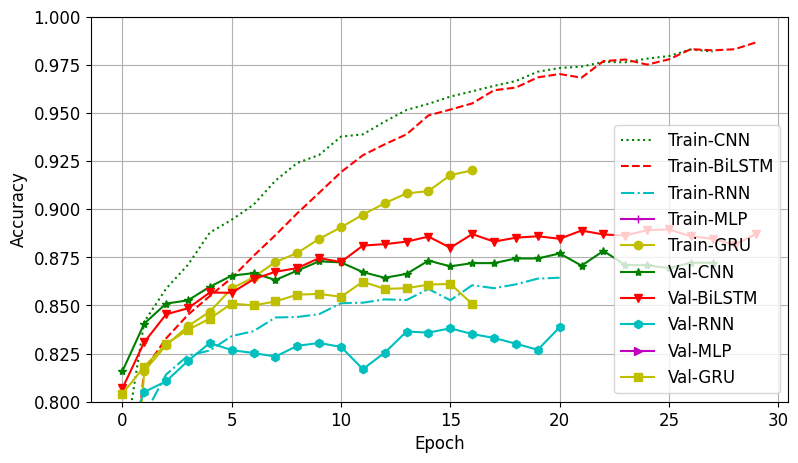

In [91]:
plt.figure(1)
plt.figure(figsize=(9,5))
plt.rcParams.update({'font.size': 12})
# summarize for accuracy
plt.plot(CNNhistory.history['accuracy'], 'g:')
plt.plot(LSTMhistory.history['accuracy'], 'r--')
plt.plot(RNNhistory.history['accuracy'], 'c-.')
plt.plot(DNNhistory.history['accuracy'], 'm-+')
plt.plot(GRUhistory.history['accuracy'], 'y-o')
plt.plot(CNNhistory.history['val_accuracy'], 'g-*')
plt.plot(LSTMhistory.history['val_accuracy'], 'r-v')
plt.plot(RNNhistory.history['val_accuracy'], 'c-h')
plt.plot(DNNhistory.history['val_accuracy'], 'm->')
plt.plot(GRUhistory.history['val_accuracy'], 'y-s')
plt.grid('True')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 1)
#plt.xlim(0,25)
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='lower right')

plt.gcf().savefig('outputs/accR1.eps', format='eps', dpi=600)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


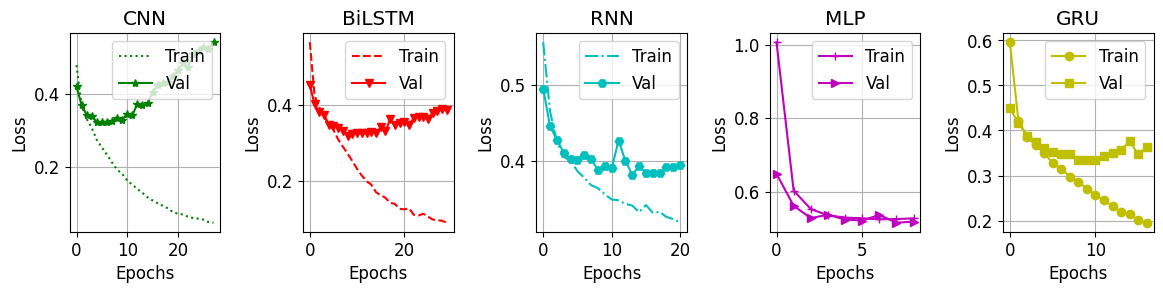

In [92]:
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
fig.tight_layout(pad=2.0)             #space between plots
#fig.set_size_inches(9,6)
plt.rcParams.update({'font.size': 12}) 

axes[0].plot(CNNhistory.history['loss'], 'g:')
axes[1].plot(LSTMhistory.history['loss'], 'r--')
axes[2].plot(RNNhistory.history['loss'], 'c-.')
axes[3].plot(DNNhistory.history['loss'], 'm-+')
axes[4].plot(GRUhistory.history['loss'], 'y-o')


axes[0].plot(CNNhistory.history['val_loss'], 'g-*')
axes[1].plot(LSTMhistory.history['val_loss'], 'r-v')
axes[2].plot(RNNhistory.history['val_loss'], 'c-H')
axes[3].plot(DNNhistory.history['val_loss'], 'm->')
axes[4].plot(GRUhistory.history['val_loss'], 'y-s')


axes[0].set_title('CNN')
axes[1].set_title('BiLSTM')
axes[2].set_title('RNN')
axes[3].set_title('MLP')
axes[4].set_title('GRU')

axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)
axes[3].grid(True)
axes[4].grid(True)

axes[0].legend(['Train', 'Val'], loc='upper right')
axes[1].legend(['Train', 'Val'], loc='upper right')
axes[2].legend(['Train', 'Val'], loc='upper right')
axes[3].legend(['Train', 'Val'], loc='upper right')
axes[4].legend(['Train', 'Val'], loc='upper right')

for i in range(0,5):
  axes[i].set_xlabel('Epochs')
  axes[i].set_ylabel('Loss')


plt.gcf().savefig('outputs/lossR1.eps', format='eps', dpi=600)

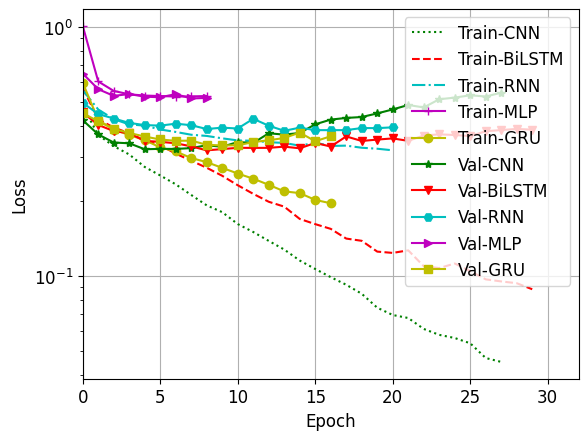

In [93]:
plt.figure(2)
plt.plot(CNNhistory.history['loss'], 'g:')
plt.plot(LSTMhistory.history['loss'], 'r--')
plt.plot(RNNhistory.history['loss'], 'c-.')
plt.plot(DNNhistory.history['loss'], 'm-+')
plt.plot(GRUhistory.history['loss'], 'y-o')
plt.plot(CNNhistory.history['val_loss'], 'g-*')
plt.plot(LSTMhistory.history['val_loss'], 'r-v')
plt.plot(RNNhistory.history['val_loss'], 'c-H')
plt.plot(DNNhistory.history['val_loss'], 'm->')
plt.plot(GRUhistory.history['val_loss'], 'y-s')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='upper right')
plt.grid('True')
plt.xlim(0,32)
plt.yscale('log')

<Figure size 640x480 with 0 Axes>

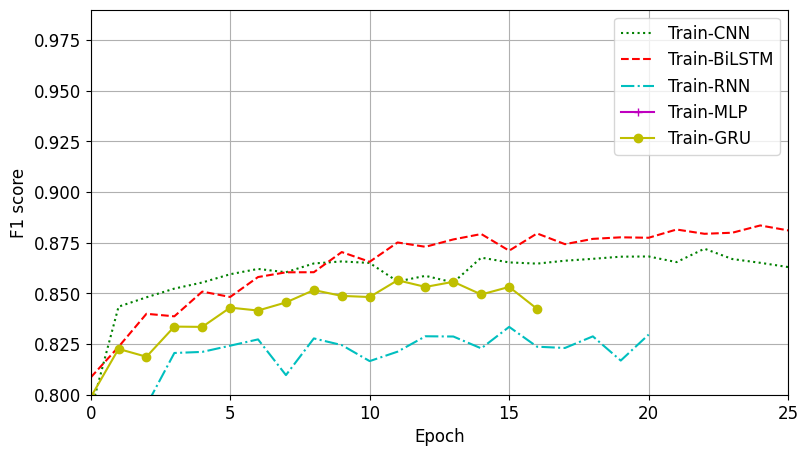

In [94]:
plt.figure(1)
plt.figure(figsize=(9,5))
plt.rcParams.update({'font.size': 12})
# summarize for accuracy
plt.plot(CNNhistory.history['val_f1_score'], 'g:')
plt.plot(LSTMhistory.history['val_f1_score'], 'r--')
plt.plot(RNNhistory.history['val_f1_score'], 'c-.')
plt.plot(DNNhistory.history['val_f1_score'], 'm-+')
plt.plot(GRUhistory.history['val_f1_score'], 'y-o')
plt.grid('True')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
plt.ylim(0.8, 0.99)
plt.xlim(0,25)
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='upper right')

## 1.11 Statistics

In [95]:
y_predCNN =(CNNmodel.predict(x_test) > 0.5).astype("int32")
y_predLSTM =(LSTMmodel.predict(x_test) > 0.5).astype("int32")
y_predRNN =(RNNmodel.predict(x_test) > 0.5).astype("int32")
y_predGRU =(GRUmodel.predict(x_test) > 0.5).astype("int32")
y_predDNN =(DNNmodel.predict(x_test) > 0.5).astype("int32")

210/210 [==============================] - 0s 1ms/step


In [96]:
# Finding precision and recall
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_test, y_predLSTM))
print(recall_score(y_test, y_predLSTM))

print(precision_score(y_test, y_predRNN))
print(recall_score(y_test, y_predRNN))

print(precision_score(y_test, y_predCNN))
print(recall_score(y_test, y_predCNN))

print(precision_score(y_test, y_predGRU))
print(recall_score(y_test, y_predGRU))

print(precision_score(y_test, y_predDNN))
print(recall_score(y_test, y_predDNN))

0.8841935483870967
0.8696065989847716
0.8199938669119902
0.8483502538071066
0.8468523002421308
0.8876903553299492
0.8383458646616542
0.8489847715736041
0.7572099262240107
0.7163705583756346


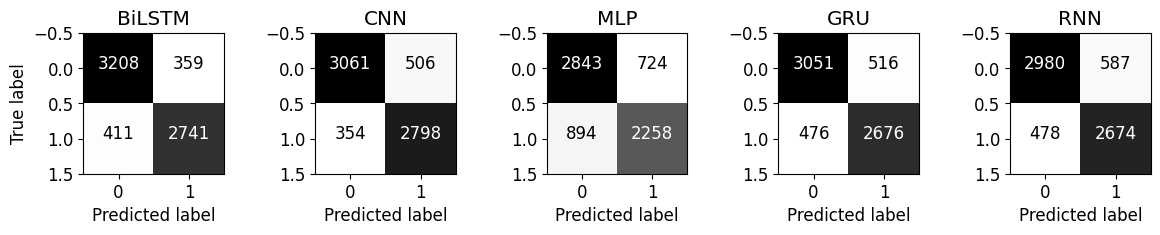

In [97]:
# Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
%matplotlib inline
import itertools

cm1 = confusion_matrix(y_true=y_test, y_pred=y_predLSTM)
cm2 = confusion_matrix(y_true=y_test, y_pred=y_predCNN)
cm3 = confusion_matrix(y_true=y_test, y_pred=y_predDNN)
cm4 = confusion_matrix(y_true=y_test, y_pred=y_predGRU)
cm5 = confusion_matrix(y_true=y_test, y_pred=y_predRNN)


fig, axes = plt.subplots(1, 5, figsize=(12, 4))
fig.tight_layout(pad=2.5)             #space between plots
#fig.set_size_inches(9,6)
plt.rcParams.update({'font.size': 12}) 
cmap=plt.cm.Greys

axes[0].imshow(cm1, interpolation='nearest', cmap=cmap)
axes[0].set_title('BiLSTM')
#axes[0].colorbar()
thresh = cm1.max() / 2.
for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
  axes[0].text(j, i, cm1[i, j],
  horizontalalignment="center",
  color="white" if cm1[i, j] > thresh else "black")
  axes[0].set_ylabel('True label')
  axes[0].set_xlabel('Predicted label')

axes[1].imshow(cm2, interpolation='nearest', cmap=cmap)
axes[1].set_title('CNN')
thresh = cm2.max() / 2.
for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
  axes[1].text(j, i, cm2[i, j],
  horizontalalignment="center",
  color="white" if cm2[i, j] > thresh else "black")
  #axes[1].set_ylabel('True label')
  axes[1].set_xlabel('Predicted label')

axes[2].imshow(cm3, interpolation='nearest', cmap=cmap)
axes[2].set_title('MLP')
thresh = cm3.max() / 2.
for i, j in itertools.product(range(cm3.shape[0]), range(cm3.shape[1])):
  axes[2].text(j, i, cm3[i, j],
  horizontalalignment="center",
  color="white" if cm3[i, j] > thresh else "black")
  #axes[2].set_ylabel('True label')
  axes[2].set_xlabel('Predicted label')

axes[3].imshow(cm4, interpolation='nearest', cmap=cmap)
axes[3].set_title('GRU')
thresh = cm3.max() / 2.
for i, j in itertools.product(range(cm4.shape[0]), range(cm4.shape[1])):
  axes[3].text(j, i, cm4[i, j],
  horizontalalignment="center",
  color="white" if cm4[i, j] > thresh else "black")
  #axes[3].set_ylabel('True label')
  axes[3].set_xlabel('Predicted label')


axes[4].imshow(cm5, interpolation='nearest', cmap=cmap)
axes[4].set_title('RNN')
thresh = cm3.max() / 2.
for i, j in itertools.product(range(cm5.shape[0]), range(cm5.shape[1])):
  axes[4].text(j, i, cm5[i, j],
  horizontalalignment="center",
  color="white" if cm5[i, j] > thresh else "black")
  #axes[4].set_ylabel('True label')
  axes[4].set_xlabel('Predicted label')


#plt.show(block=False)

plt.gcf().savefig('results/cmR1.pdf', format='pdf', dpi=1200)

## 1.12 Testing 

In [ ]:
def predict_DL(surname):
  testename = prepare_encod_names({surname})   # Now the names are encod as a vector of numbers with weight
  resu=(CNNmodel.predict(testename) > 0.5).astype("int32")
  if int(resu)==1:
    return 'homme'
  else:
    return 'femme'

predict_DL('yann')

